In [1]:
import numpy as np
import sys
np.set_printoptions(precision=10, linewidth=200, suppress=True)
import psi4
from helper_PFCI import PFHamiltonianGenerator
from helper_PFCI import Determinant
from helper_cqed_rhf import cqed_rhf
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import os
import json

In [2]:
# # options for mgf
# mol_str = """
# Li
# H 1 1.5
# symmetry c1
# """

# options_dict = {
#     "basis": "6-31G",
#     "scf_type": "pk",
#     "e_convergence": 1e-10,
#     "d_convergence": 1e-10,
#     "save_jk" : True
# }


# psi4.set_options(options_dict)
# mol = psi4.geometry(mol_str)


In [3]:
# mol_str = """
# Li
# H 1 1.5
# symmetry c1
# """

# options_dict = {
#     "basis": "6-31G",
#     "scf_type": "pk",
#     "e_convergence": 1e-10,
#     "d_convergence": 1e-10,
# }

# cavity_free_dict = {
#     'omega_value' : 0.0,
#     'lambda_vector' : np.array([0, 0, 0.0]),
#     'ci_level' : 'cas',
#     'nact_orbs' : 11, 
#     'nact_els' : 4,
#     'full_diagonalization' : True,
#     'number_of_photons' : 0
# }

# # Need to determine appropriate omega later~
# #cavity_dict = {
# #    'omega_value' : 0.0,
# #    'lambda_vector' : np.array([0, 0, 0.0]),
# #    'ci_level' : 'cas',
# #    'nact_orbs' : 11, 
# #    'nact_els' : 4,
# #    'full_diagonalization' : True,
# #    'number_of_photons' : 0
# #}

# mol = psi4.geometry(mol_str)
# psi4.set_options(options_dict)

# test_pf = PFHamiltonianGenerator(
#     mol_str,
#     options_dict,
#     cavity_free_dict
# )



In [4]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""

mol_str = """
Li
H 1 1.5
symmetry c1
"""

N_R = 200
# N_el = 50
# all_states = np.linspace(0, N_el-1, N_el, dtype=int)
r_array = np.linspace(1.4, 2.2, N_R)

# E_array = np.zeros((N_R, N_el))
# Mu_array = np.zeros((N_R, N_el, N_el, 3))
# psi4.set_options(options_dict)

# r_idx = 0
# for r in r_array:
#     mol_str = mol_tmpl.replace("**R**", str(r))
#     print(mol_str)
#     mol = psi4.geometry(mol_str)
#     #scf_e, wfn = psi4.energy('SCF', return_wfn=True)
#     #fci_energy = psi4.energy('fci',ref_wfn=wfn)
    
#     LiH = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)
#     #assert np.isclose(fci_energy, LiH.CIeigs[0], 1e-7)
#     # sort out states with dipole-allowed transition from ground state
#     singlet_states = LiH.sort_dipole_allowed_states( N_el)
#     print(singlet_states)
    
#     E_array[r_idx, :] = LiH.CIeigs[singlet_states]
#     Mu_array[r_idx, :, :, :] = LiH.compute_dipole_moments(singlet_states)
    
#     # uncomment to try not sorting singlet states
#     #E_array[r_idx, :] = LiH.CIeigs[all_states]
#     #Mu_array[r_idx, :, :, :] = LiH.compute_dipole_moments(all_states)
    
#     r_idx += 1



In [5]:
from matplotlib import pyplot as plt
somedir=os.getcwd()
print(somedir)

/Users/rmandern/code/SCQED-PCQED/Formaldehyde


In [6]:
# np.save("LiH_631G_FCI_E_array", E_array)
# np.save("LiH_631G_Mu_array", Mu_array)

In [7]:
print(os.path.abspath("."))

#E_array = np.load(LiH_631G_FCI_E_Array.npy)
E_array_1000 = np.load('CH2O_ccpVDZ_CASCI_88_1000_dipole_allowed_E_Array.npy')
Mu_array_1000 = np.load('CH2O_ccpVDZ_CASCI_88_1000_dipole_allowed_Mu_Array.npy')
# r_array = np.load('LiH_r_array.npy')

/Users/rmandern/code/SCQED-PCQED/Formaldehyde


In [8]:
print(E_array_1000.shape)
print(Mu_array_1000.shape)

(1000,)
(1000, 1000, 3)


In [9]:
# open json file
f = open("CH2O_CO_r_1.3_casci_cc-pVDZ_n_act_els_8_n_act_orbs_8_dipole_allowed.json")
data = json.load(f)


In [10]:
# get the array of lambda values from the json file
lambdas = data["model"]["lambda_vector"]

In [11]:
# get the omega value from the json file
omega_cav = data["model"]["omega"]

In [12]:
# determine how many lambda values will be in the scan
N_l = len(lambdas)
print(N_l)

11


\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} + \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\gamma = 1}^N \lambda \cdot \mu_{\alpha, \gamma}(R) \lambda \cdot \mu_{\gamma, \beta} \delta_{nm}
\end{equation}


In [13]:
def build_pf_hamiltonian(n_el, n_ph, E_R, omega, lamvec, mu):
    """
    Given an array of n_el E_R values and an n_ph states with fundamental energy omega
    build the PF Hamiltonian
    
    n_el : int
        the number of electronic states (n_el = 1 means only ground-state)
    
    n_ph : int
        the number of photon occupation states (n_ph = 1 means only the |0> state)
    
    E_R : np.array of floats
        the electronic energies
        
    omega : float
        the energy of the photonic mode
        
    lamvec : np.array of floats
        the lambda vector
        
    mu : (n_el x n_el x 3) np.array of floats 
        mu[i, j, k] is the kth cartesian component of the dipole moment expectation value between 
        state i and state j
    
    """
    H_PF = np.zeros((n_el * n_ph, n_el * n_ph))
    
    # take care of the diagonals first
    # bare electronic and photonic energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            H_PF[na,na] = E_R[a] + n * omega
        
    # diagonal dipole self energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            for g in range(n_el):
                H_PF[na,na] += 0.5 * np.dot(lamvec, mu[a,g,:]) * np.dot(lamvec, mu[g,a,:])
            
    # off-diagonal dipole self energy
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            for b in range(n_el):
                nb = n * n_el + b
                for g in range(n_el):
                    if a != b:
                        H_PF[na, nb] += 0.5 * np.dot(lamvec, mu[a,g,:]) * np.dot(lamvec, mu[g, b, :])
                
    # off-diagonal bilinear coupling
    for n in range(n_ph):
        for a in range(n_el):
            na = n * n_el + a
            
            for m in range(n_ph):
                for b in range(n_el):
                    mb = m * n_el + b
                    
                    if n == (m-1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na,mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m) 
                        
                    elif n == (m+1) and a != b:
                        #print(n, a, na, m, b, mb)
                        H_PF[na, mb] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1) 
                        H_PF[mb, na] = -np.sqrt(omega / 2) * np.dot(lamvec, mu[a,b,:]) * np.sqrt(m+1)
                        
    
    return H_PF

\begin{equation}
\hat{H}_{\alpha n, \beta m} = \left( E_{\alpha}(R) + n \omega \right) \delta_{\alpha \beta} \delta_{nm} + \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{\alpha \beta}(R) \left(\sqrt{n} \delta_{n,m-1} + \sqrt{n+1} \delta_{n,m+1} \right)  \\
+\frac{1}{2} \sum_{\gamma = 1}^N \lambda \cdot \mu_{\alpha, \gamma}(R) \lambda \cdot \mu_{\gamma, \beta} \delta_{nm}
\end{equation}


In [14]:
np.set_printoptions(precision=6, linewidth=200, suppress=True)
omega_cav = 0.3582 
# lambda_vector = np.array([0.0, 0.0, 0.045])

We want to investigate the mean absolute error of a given polariton potential energy surface as a 
function of electronic and photonic truncation:

$$ {\rm MAE} = \frac{1}{N_R} \sum_i^{N_R} \left| E(R_i) - E^{'}(R_i) \right| $$

where $E^{'}(R_i)$ is a value of the polaritonic PES for a truncated level of theory and $E(R_i)$ is the exact value.

In [15]:
# def MAE(E, Ep):
#     """
#     function to return the mean absolute error of the approximate PES stored in Ep relative to 
#     the exact PES stored in E
#     """
#     # get length
#     _NR = len(E)
    
#     # take element-by-element difference
#     _diff = E - Ep
    
#     # compute absolute value of differences
#     _absdiff = np.abs(_diff)
    
#     # return sum divided by _NR
#     return np.sum(_absdiff) / _NR

    

In [16]:
# set the electronic and photonic basis
N_el = 2
N_ph = 2

# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_2_2 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array_1000, omega_cav, lam, Mu_array_1000)
    pf_e, pf_c = np.linalg.eigh(_HPF)
    _pcqed_2_2[ctr, :] = pf_e
    ctr += 1


(11, 3)


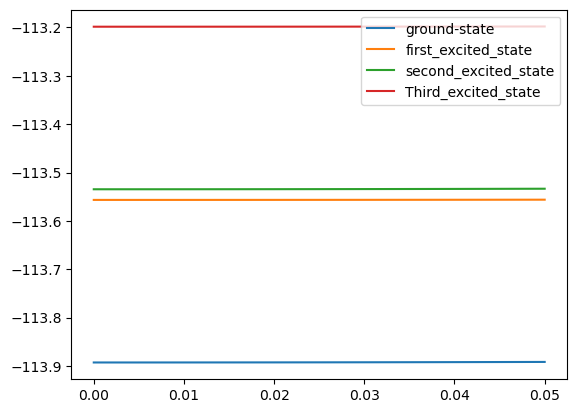

In [17]:
lam_np = np.array(lambdas)
print(np.shape(lambdas))
plt.plot(lam_np[:,2], _pcqed_2_2[:,0], label="ground-state")
plt.plot(lam_np[:,2],_pcqed_2_2[:,1], label='first_excited_state')
plt.plot(lam_np[:,2],_pcqed_2_2[:,2], label='second_excited_state')
plt.plot(lam_np[:,2],_pcqed_2_2[:,3], label='Third_excited_state')
# plt.plot(lambdas[:,2],_pcqed_22[:,4], label='fourth_excited_state')
# plt.ylim(-0.0002, -0.0007)
# plt.ylim(-113.556, -113.50)
# plt.grid()
plt.legend()

In [ ]:
# set the electronic and photonic basis
N_el = 300
N_ph = 5

# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_3005 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array_1000, omega_cav, lam, Mu_array_1000)
    pf_e, pf_c = np.linalg.eigh(_HPF)
    _pcqed_3005[ctr, :] = pf_e
    ctr += 1


In [ ]:
lam_np = np.array(lambdas)
print(np.shape(lambdas))
plt.plot(lam_np[:,2], _pcqed_22[:,0], label="ground-state")
plt.plot(lam_np[:,2],_pcqed_22[:,1], label='first_excited_state')
plt.plot(lam_np[:,2],_pcqed_22[:,2], label='second_excited_state')
plt.plot(lam_np[:,2],_pcqed_22[:,3], label='Third_excited_state')
# plt.plot(lambdas[:,2],_pcqed_22[:,4], label='fourth_excited_state')
# plt.ylim(-0.0002, -0.0007)
# plt.ylim(-113.556, -113.50)
# plt.grid()
plt.legend()

In [ ]:
# print(np.shape(lambdas))
# print(np.shape(_pcqed_22))
# print(lambdas)
# print(_pcqed_22)

In [ ]:

N_el = 4
N_ph = 2

# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_42 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array_F, omega_cav, lam, Mu_array_F)
    pf_e, pf_c = np.linalg.eigh(_HPF)
    _pcqed_42[ctr, :] = pf_e
    ctr += 1


In [ ]:
plt.plot(lam_np[:,2], _pcqed_42[:,0], label="ground-state")
plt.plot(lam_np[:,2],_pcqed_42[:,1], label='first_excited_state')
plt.plot(lam_np[:,2],_pcqed_42[:,2], label='second_excited_state')
plt.plot(lam_np[:,2],_pcqed_42[:,3], label='Third_excited_state')
plt.plot(lam_np[:,2],_pcqed_42[:,4], label='fourth_excited_state')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-0.0002, -0.0007)
# plt.ylim(-113.556, -113.50)
# plt.grid()
plt.legend()

In [ ]:
N_el = 5
N_ph = 2

# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_52 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array_F, omega_cav, lam, Mu_array_F)
    pf_e, pf_c = np.linalg.eigh(_HPF)
    _pcqed_52[ctr, :] = pf_e
    ctr += 1


In [ ]:
# plt.plot(lam_np[:,2], _pcqed_72[:,0], label="ground-state")
plt.plot(lam_np[:,2],_pcqed_52[:,1], label='first_excited_state')
plt.plot(lam_np[:,2],_pcqed_52[:,2], label='second_excited_state')
plt.plot(lam_np[:,2],_pcqed_52[:,3], label='Third_excited_state')
plt.plot(lam_np[:,2],_pcqed_52[:,4], label='fourth_excited_state')
# plt.plot(lambdas[:,2],_pcqed_72[:,5], label='fifth_excited_state')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-0.0002, -0.0007)
# plt.ylim(-113.556, -113.50)
# plt.grid()
plt.legend()

In [ ]:
N_el = 10
N_ph = 2

# create an array of zeros to store the PCQED eigenvalues for each value of lambda
_pcqed_102 = np.zeros((N_l, N_el * N_ph))
# loop over values of lambda, build Hamiltonian, capture eigenvalues
ctr = 0
for lam in lambdas:
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array_F, omega_cav, lam, Mu_array_F)
    pf_e, pf_c = np.linalg.eigh(_HPF)
    _pcqed_102[ctr, :] = pf_e
    ctr += 1


In [ ]:
# plt.plot(lam_np[:,2], _pcqed_72[:,0], label="ground-state")
plt.plot(lam_np[:,2],_pcqed_102[:,1], label='first_excited_state')
plt.plot(lam_np[:,2],_pcqed_102[:,2], label='second_excited_state')
plt.plot(lam_np[:,2],_pcqed_102[:,3], label='Third_excited_state')
plt.plot(lam_np[:,2],_pcqed_102[:,4], label='fourth_excited_state')
# plt.plot(lambdas[:,2],_pcqed_72[:,5], label='fifth_excited_state')
plt.xlabel('lambda')
plt.ylabel('Energy')
# plt.ylim(-0.0002, -0.0007)
# plt.ylim(-113.556, -113.50)
# plt.grid()
plt.legend()

In [ ]:
N_el = 30
N_ph = 30
pf_array_30_30 = np.zeros((N_R, N_el * N_ph ))
for k in range(N_R):           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)
    pf_array_30_30[k,:] = pf_e

print(np.shape(_HPF))
np.save("LiH_631G(005)_FCI_pf_array_30_30", pf_array_30_30)

In [ ]:

plt.plot(r_array, pf_array_30_30[:,0],label="PCQED_005_nel30_np30_E0")
plt.plot(r_array, pf_array_30_30[:,1],label="LP")
# plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
plt.plot(r_array, E_array[:,1], label="E1")
plt.plot(r_array, pf_array_30_30[:,2],'ro', label="UP")
plt.plot(r_array, pf_array_30_30[:,3],'bo', label="UP+1")
plt.plot(r_array, pf_array_30_30[:,4],'yo', label="UP+2")
plt.legend()


In [ ]:
N_el = 50
N_ph = 10
pf_array_50_10 = np.zeros((N_R, N_el * N_ph ))
for k in range(N_R):           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)
    pf_array_50_10[k,:] = pf_e
    
np.save("LiH_631G(005)_FCI_pf_array_50_10", pf_array_50_10)

In [ ]:
plt.plot(r_array, pf_array_50_10[:,0],label="PCQED_005_nel30_np30_E0")
plt.plot(r_array, pf_array_50_10[:,1],label="LP")
# plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
plt.plot(r_array, E_array[:,1], label="E1")
plt.plot(r_array, pf_array_50_10[:,2],'ro', label="UP")
plt.plot(r_array, pf_array_50_10[:,3],'bo', label="UP+1")
plt.plot(r_array, pf_array_50_10[:,4],'yo', label="UP+2")
plt.legend()


In [ ]:
N_el = 50
N_ph = 20
pf_array_50_20 = np.zeros((N_R, N_el * N_ph ))
for k in range(N_R):           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)
    pf_array_50_20[k,:] = pf_e
    


In [ ]:
plt.plot(r_array, pf_array_50_20[:,0],label="PCQED_005_nel30_np20_E0")
plt.plot(r_array, pf_array_50_20[:,1],label="LP")
# plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
plt.plot(r_array, E_array[:,1], label="E1")
plt.plot(r_array, pf_array_50_20[:,2],'ro', label="UP")
plt.plot(r_array, pf_array_50_20[:,3],'bo', label="UP+1")
plt.plot(r_array, pf_array_50_20[:,4],'yo', label="UP+2")
plt.legend()

In [ ]:

#plt.plot(r_array, Eg_QED_FCI_Np_1)
# plt.plot(r_array, E_array[:,0],'bo',  label="No cavity")
# plt.plot(r_array, pf_array_3_2[:,0],'y^' ,label="PCQED_nel3_np2_E0")
# plt.plot(r_array, pf_array_10_5[:,0],'bs' , ms=8,mfc='none',label="PCQED_nel10_np5_E0")
# plt.plot(r_array, pf_array_30_2[:,0],'md' , ms=7,mfc='none',label="PCQED_nel30_np2_E0")
plt.plot(r_array, pf_array_30_30[:,0],label="PCQED_nel30_np30_E0")
plt.plot(r_array, pf_array_50_10[:,0],label="PCQED_nel50_np10_E0")
plt.plot(r_array, pf_array_50_20[:,0],label="PCQED_005_nel30_np20_E0")
# plt.plot(r_array, pf_array[:,1],label="LP")
# plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
# plt.plot(r_array, E_array[:,1], label="E1")
# plt.plot(r_array, pf_array[:,2],'ro', label="UP")
# plt.plot(r_array, pf_array[:,3],'bo', label="UP+1")
# plt.plot(r_array, pf_array[:,4],'yo', label="UP+2")
# plt.plot(QEDCI_001_np1_s0[:,0], QEDCI_001_np1_s0[:,1],'rv' , ms=7,mfc='none', label="QEDCI_001_np1_s0")
# plt.plot(QEDCI_001_np5_s0[:,0], QEDCI_001_np5_s0[:,1],'ms' , ms=7,mfc='none', label="QEDCI_001_np5_s0")
# plt.plot(QEDCI_001_np10_s0[:,0], QEDCI_001_np10_s0[:,1],linestyle="dashdot" ,label="QEDCI_001_np10_s0")
# plt.plot(QEDCI_005_np1_s0[:,0], QEDCI_005_np1_s0[:,1],'ro',ms = 6, mfc = 'none', label="QEDCI_005_np1_s0")
# plt.plot(QEDCI_005_np5_s0[:,0], QEDCI_005_np5_s0[:,1],'bo',ms=3,mfc ='none', label="QEDCI_005_np5_s0")
# plt.plot(QEDCI_005_np10_s0[:,0], QEDCI_005_np10_s0[:,1],'ys' , ms=7,mfc='none', label="QEDCI_005_np10_s0")
# plt.plot(QEDCI_001_np1_s1[:,0], QEDCI_001_np1_s1[:,1], label="QEDCI_001_s1",color='black',linestyle='dotted')
# plt.plot(QEDCI_001_np1_s1[:,0], QEDCI_001_np1_s2[:,1], label="QEDCI_001_s2",color='pink',linestyle='dotted')
# plt.xlim(1.4, 2.0)
# plt.ylim(-8.000, -7.980)
# plt.ylim(-8.000, -7.9875)
#lt.title("nel_3__np_40")
#plt.plot(r_array, pf_array[:,4])
plt.legend()
# plt.savefig("LiH_0.05_comparsion.png")


In [ ]:
#plt.plot(r_array, Eg_QED_FCI_Np_1)
# plt.plot(r_array, E_array[:,0],'bo',  label="No cavity")

# State nel=3 and nph =2, all pf_energy(pcqed) surfaces
# plt.plot(r_array, pf_array_3_2[:,0],'k*' ,label="PCQED_nel3_np2_E0")
# plt.plot(r_array, pf_array_3_2[:,1],'k*' ,label="PCQED_nel3_np2_E1,LP")
plt.plot(r_array, pf_array_3_2[:,2],'k*' ,label="PCQED_nel3_np2_E2,UP")
plt.plot(r_array, pf_array_3_2[:,3],'ko' ,label="PCQED_nel3_np2_E3,UP+1")
# State nel=10 and nph =5, all pf_energy(pcqed) surfaces
# plt.plot(r_array, pf_array_10_5[:,0],'ms' , ms=8,mfc='none',label="PCQED_nel10_np5_E0")
# plt.plot(r_array, pf_array_10_5[:,1],'ms' , ms=8,mfc='none',label="PCQED_nel10_np5_E1, LP")
plt.plot(r_array, pf_array_10_5[:,2],'ms' , ms=8,mfc='none',label="PCQED_nel10_np5_E2, UP")
# plt.plot(r_array, pf_array_10_5[:,4],'mo' , ms=8,mfc='none',label="PCQED_nel10_np5_E3, UP+1")
# State nel=50 and nph =10, all pf_energy(pcqed) surfaces
# plt.plot(r_array, pf_array_50_10[:,0],'g^',label="PCQED_nel50_np10_E0")
# plt.plot(r_array, pf_array_50_10[:,1],'g^',label="PCQED_nel50_np10_E1,LP")
plt.plot(r_array, pf_array_50_10[:,2],'g^',label="PCQED_nel50_np10_E2,UP")
# plt.plot(r_array, pf_array_50_10[:,4],'go',label="PCQED_nel50_np10_E3,UP+1")


# plt.plot(QEDCI_005_np1_s1[:,0], QEDCI_005_np1_s1[:,1],'yo',ms = 6, mfc = 'none', label="QEDCI_005_np1_s1")
# plt.plot(QEDCI_005_np5_s1[:,0], QEDCI_005_np5_s1[:,1],'yo',ms=3,mfc ='none', label="QEDCI_005_np5_s1")
# plt.plot(QEDCI_005_np10_s1[:,0], QEDCI_005_np10_s1[:,1],'y',linestyle="dashed", label="QEDCI_005_np10_s1")


# plt.plot(QEDCI_005_np1_s2[:,0], QEDCI_005_np1_s2[:,1],'ro',ms = 6, mfc = 'none', label="QEDCI_005_np1_s2")
# plt.plot(QEDCI_005_np5_s2[:,0], QEDCI_005_np5_s2[:,1],'ro',ms=3,mfc ='none', label="QEDCI_005_np5_s2")
# plt.plot(QEDCI_005_np10_s2[:,0], QEDCI_005_np10_s2[:,1],'r',linestyle="dashed", label="QEDCI_005_np10_s2")

# plt.ylim(-7.84, -7.86)
#lt.title("nel_3__np_40")
#plt.plot(r_array, pf_array[:,4])
plt.legend()
# plt.savefig("LiH_0.05_LPUP.png")






# print(pf_array_3_2[:,2])


# print(E2_array[:,4][-14:])
# print(E4_array[:,2][-14:])
# # print(pf_array)
# print(np.shape(E4_array))


In [ ]:
# Print memory usage
memory_usage = get_memory_usage()
print(f"Memory usage: {memory_usage} MB ")

In [ ]:
'''
Value Swapping

'''
# #swaping values 
# pf_array_3_2[:,3][-20:]= pf_array_3_2[:,2][-20:]
# pf_array_3_2[:,2][-20:] = pf_array_3_2[:,3][-20:]
# plt.plot(r_array, pf_array_3_2[:,2],'k*' ,label="PCQED_nel3_np2_E2,UP")
# plt.plot(r_array, pf_array_3_2[:,3],'ko' ,label="PCQED_nel3_np2_E3,UP+1")

plt.legend()

In [ ]:
#test
#plt.plot(r_array, Eg_QED_FCI_Np_1)
plt.plot(r_array, pf_array[:,0],label="Eg")
plt.plot(r_array, pf_array[:,1],label="LP")
plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
plt.plot(r_array, E_array[:,1], label="E1")
#plt.plot(r_array, E3_QED_FCI_Np_1, label="QED-FCI")
#plt.plot(r_array, E3_QED_FCI_Np_5, label="QED-FCI")
plt.plot(r_array, E2_array[:,4],'ro', label="UP")
plt.plot(r_array, pf_array[:,3],'bo', label="UP+1")
plt.plot(r_array, E4_array[:,2],'yo', label="UP+2")
# plt.xlim(1.9, 2.1)
# plt.ylim(-7.885, -7.825)
#lt.title("nel_3__np_40")
#plt.plot(r_array, pf_array[:,4])
#lt.savefig("LiH_631G_nel3_p40.png")
plt.legend()


In [ ]:
plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
plt.plot(r_array, E_array[:,1], label="E1")

plt.plot(r_array, pf_array[:,3],'violet', label="E3")
plt.plot(r_array, pf_array[:,0],'yellow', label="E0")
plt.plot(r_array, pf_array[:,5],'pink', label="UP+3")
# plt.xlim(1.9, 2.1)
# plt.ylim(-7.885, -7.825)
plt.legend()



In [ ]:

# plt.plot(r_array, Eg_QED_FCI_Np_1)


# plt.plot(r_array, pf_array[:,1],label="LP")
# plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
# plt.plot(r_array, E_array[:,1], label="E1")

# plt.plot(r_array[40:], pf_array[40:,2],'bo', label="UP")
# plt.plot(r_array, pf_array[:,3],'yellow', label="UP+1")
# plt.plot(r_array[:50], pf_array[:50,4],'bo', label="UP+2")
# plt.plot(r_array[:50], pf_array[:50,2],'yellow', label="UP")
# plt.plot(r_array, pf_array[:,3],'yellow', label="UP+1")
# plt.plot(r_array[40:], pf_array[40:,4],'ro', label="UP+2")
# plt.plot(r_array, pf_array[:,5],'pink', label="UP+3")

# plt.plot(r_array, pf_array[:,4])
# plt.legend()

# print(f"{pf_array[:,4]}............ ")
# print(pf_array[:,2])
# print(pf_array[40:,2])
# print(pf_array[:50,2])
# print(pf_array)

In [ ]:
#plt.plot(r_array, Eg_QED_FCI_Np_1)
#plt.plot(r_array, pf_array[:,0],label="Eg")
plt.plot(r_array, pf_array[:,1],label="LP")
plt.plot(r_array, E_array[:,0]+omega_cav, label="E0 + omega")
plt.plot(r_array, E_array[:,1], label="E1")
#plt.plot(r_array, E3_QED_FCI_Np_1, label="QED-FCI")
#plt.plot(r_array, E3_QED_FCI_Np_5, label="QED-FCI")
plt.plot(r_array, pf_array[:,2],'ro', label="UP")
plt.plot(r_array, pf_array[:,3],'bo', label="UP+1")
plt.plot(r_array, pf_array[:,4],'yo', label="UP+2")
# plt.xlim(1.9, 2.1)
# plt.ylim(-7.885, -7.825)
#lt.title("nel_3__np_40")
#plt.plot(r_array, pf_array[:,4])
#lt.savefig("LiH_631G_nel3_p40.png")
plt.legend()


In [ ]:
for i in range(N_R):
    print(F'{r_array[i]}, {pf_array[i,0]}, {pf_array[i,1]}, {pf_array[i,2]}, {pf_array[i,3]}, {pf_array[i,3]} ')
      

In [ ]:
# we will compare to this!
#PF_2020 = np.copy(PF_EIG)
#PF_22 = np.copy(PF_EIG)

print(MAE(PF_5020[:,0], PF_2020[:,0]))
print(MAE(PF_5020[:,1], PF_2020[:,1]))
print(MAE(PF_5020[:,2], PF_2020[:,2]))

print(MAE(PF_5050[:,0], PF_2020[:,0]))
print(MAE(PF_5050[:,1], PF_2020[:,1]))
print(MAE(PF_5050[:,2], PF_2020[:,2]))

print(MAE(PF_5050[:,0], PF_5020[:,0]))
print(MAE(PF_5050[:,1], PF_5020[:,1]))
print(MAE(PF_5050[:,2], PF_5020[:,2]))
#omega_cav = 0.120000
#lambda_vector = np.array([0, 0.0, 0.05])
#numpy.savetxt(fname, X, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ', encoding=None)[source]
np.savetxt('PF_5050_om_zp12_lamz_zp05.out', PF_5050, fmt='%16.12e', delimiter=',', newline='\n', header="N_el = 50, N_ph = 50, omega = 0.12, lambda = 0., 0., 0.05, r_array = np.linspace(1.4, 2.2, N_R)" ) 


In [ ]:
for i in range(20):

    for j in range(20):
        N_el = N_el_array[i]
        N_ph = N_ph_array[j]
        print(F'{N_el}, {N_ph}, {MAE_array[i, j, 0]}, {MAE_array[i, j, 1]}, {MAE_array[i, j, 2]}')
        
    print('')


In [ ]:
#plt.plot(r_array, PF_2020[:,0], 'black', label="LP - 20-20")
#plt.plot(r_array, PF_WTRIP[:,0], 'ro', label="LP - 2-2")
plt.plot(r_array, PF_2020[:,1], 'r--', label="LP - 20-2")
plt.plot(r_array, PF_WTRIP[:,2], 'purple', label="UP - 20-20")
plt.plot(r_array, PF_2020[:,2], 'b--', label="UP - 20-2")
plt.plot(r_array, PF_WTRIP[:,3], 'bo', label="UP - 2-2")
plt.legend()
plt.show()


plt.plot(r_array,PF_2020[:,2]- PF_WTRIP[:,3])
#plt.xlim(1.62, 2.2)
plt.show()

print(PF_2020[:,2]- PF_WTRIP[:,3])

In [ ]:
plt.plot(r_array, PF_2020[:,1], 'black', label="LP - 20-20")
plt.plot(r_array, PF_22[:,1], 'ro', label="LP - 2-2")
plt.plot(r_array, PF_202[:,1], 'r--', label="LP - 20-2")
plt.plot(r_array, PF_2020[:,2], 'purple', label="UP - 20-20")
plt.plot(r_array, PF_202[:,2], 'b--', label="UP - 20-2")
plt.plot(r_array, PF_22[:,2], 'bo', label="UP - 2-2")
plt.legend()
plt.show()

#plt.plot(r_array, PF_EIG[:,2], 'b--')
#plt.plot(r_array, E_array[:,0]+omega_cav)
#plt.plot(r_array, E_array[:,2])
#plt.plot(r_array, E_array[:,3])
#plt.plot(r_array, PF_EIG[:,3])
#plt.plot(r_array, PF_EIG[:,4])
#plt.plot(r_array, PF_EIG[:,5])





In [ ]:

mol_str = """
Li
H 1 1.8
symmetry c1
"""

options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    "save_jk" : True
}

cavity_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0]),
    'ci_level' : 'fci',
    'full_diagonalization' : True,
    'number_of_photons' : 0
}



E_r_1p8_array = np.zeros(N_el)
Mu_r_1p8_array = np.zeros((N_el, N_el, 3))



mol = psi4.geometry(mol_str)
scf_e, wfn = psi4.energy('SCF', return_wfn=True)
fci_energy = psi4.energy('fci',ref_wfn=wfn)

LiH = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
assert np.isclose(fci_energy, LiH.CIeigs[0], 1e-7)
# sort out states with dipole-allowed transition from ground state
singlet_states = LiH.sort_dipole_allowed_states( N_el)
E_r_1p8_array[:] = LiH.CIeigs[singlet_states]
Mu_r_1p8_array = LiH.compute_dipole_moments(singlet_states)
    



In [ ]:
lam_z = np.linspace(0, 0.1, 50)
pol_v_l = np.zeros((50,3))
print(lam_z)

In [ ]:
N_el = 20
N_ph = 20
for i in range(50):
    lambda_vector[2] = lam_z[i]           
    _HPF = build_pf_hamiltonian(N_el, N_ph, E_array[k,:], omega_cav, lambda_vector, Mu_array[k, :, :, :])
    pf_e, pf_c = np.linalg.eigh(_HPF)
    pol_v_l[i,:] = pf_e[:3]
    print(lam_z[i], pf_e[0], pf_e[1], pf_e[2])

In [ ]:
plt.plot(lam_z, pol_v_l[:,0], label='g')
plt.plot(lam_z, pol_v_l[:,1], label='LP')
plt.plot(lam_z, pol_v_l[:,2], label='UP')

plt.legend()
plt.show()